**Scene:**

Its 3pm and your supervisor has just handed you their old Fortran77 code that they swear "solved this problem in the 80s" and "is really smartly written and easy to follow". After the meeting you take one look at the code and realize it doesn't. And it's not. 

But, you said you'd have results by the group meeting the following day, so lets see if we can understand what it is doing, fix it up, and get some results!

$_{\rm Also,\ this\ code\ has\ somehow\ already\ been\ converted\ into\ python\ 3.\ who\ knows}$






**In this question we will try to develop some smart coding practices, and try to improve upon some poorly written code.**

You are provided with the following code in this workbook, 
which is both memory and computationally inefficient (and poorly commented)

Your task is to speed the code up as much as possible, and to make it as memory efficient as possible.
Also, you should comment "important" lines with what operations they seem to be performing

Hints:

**1.) Try to get rid of every single for loop (vectorize everything you can)**

**2.) Get rid of duplicate memory allocation**

> e.g. 

> array1 = np.zeros((10,10))

> array2 = array1 * 2.0

> array3 = array2**2 

> Instead just use array1 = array1 * 2.0 ; array1 = array1**2, etc.


**Marks will be based on:**

1.) run time of your improved code compared to the original (0 for loops are needed)

2.) memory usage of your code compared to the original

3.) Documentation. Fix missing comments (hint: look for lines that start with "###"), and feel free to add additional ones if you feel they are necessary

**Lets first test some good coding practices here:**

1.) **Never use for loops unless you have to - super slow! Vectorize everything**

e.g.:

In [1]:
# Make random data arrays

import numpy as np
import time

N = 10000000
A = np.arange(N)
B = np.random.uniform(size=N)

print("data created")

# test time to use for loop vs vectorized version

# Bad Way
start = time.time()
total = 0
for i in range(N):
    total += A[i] * B[i]
end = time.time()
print("For loop: total = %d in time = %d seconds"%(total, end-start))

# Good Way
start = time.time()
total = np.sum(A*B)
end = time.time()
print("Vectorized: total = %d in time = %d seconds"%(total, end-start))


data created
For loop: total = 24997813229339 in time = 30 seconds
Vectorized: total = 24997813229339 in time = 0 seconds


2.) **Don't convert lists to arrays/array to lists unless necessary for some reason**

e.g.:


In [2]:
N = 10000000

# Bad Way
start = time.time()
A = []
for i in range(N):
    A_i = np.random.uniform()
    A.append(A_i)

A = np.array(A)
end = time.time()
print("List/For loop: total = %d in time = %d seconds"%(total, end-start))


# Good Way
start = time.time()
A = np.random.uniform(size=N)
end = time.time()
print("Array Vectorized: total = %d in time = %d seconds"%(total, end-start))


List/For loop: total = 24997813229339 in time = 16 seconds
Array Vectorized: total = 24997813229339 in time = 0 seconds


3.) **Don't duplicate arrays unless you actually need the multiple versions**

e.g.:

In [3]:
A = np.random.uniform(size=(100,100))
B = A*2
C = B**2

# you've now tripled the memory usage to calculate C from A. Unless you actually need A and B later, don't do this. 
# Just do:
A = np.random.uniform(size=(100,100))
A = A*2
A = A**2

# or 

A = np.random.uniform(size=(100,100))
A *= 2
A = A**2

# or whatever

**Code Outline**
The code you will be working with is a mockup of a three dimensional "large scale structure survey", or a "mock" observation. Using this code we want to populate our field of view with the flux from a number (Nhalo) of dark matter halos. 

Each of these halos will be given:

1.) a randomly drawn position in (ra [deg], dec [deg], distance [Mpc (comoving)])

2.) a randomly drawn Mass in [Msun], drawn from an analytical Halo Mass Function (HMF) 


For each of these halos you will calculate a Luminosity, based on the given Mass-to-Luminosity relation mass_to_luminosity(mass). 

You will then bin the luminosity of these halos into a three dimensional map/array of size (npix_x, npix_y, npix_z) which represents (ra, dec, distance - aka a three dimensional data cube, where each voxel (3D pixel) represents the luminosity coming from that region of space.)

You will then perform a simple "analysis" of this map 

**first, a bit on what a "dark matter halo mass function" is:**

The Halo Mass function describes the number of dark matter halos of a given mass M

For this example we will use a simplified version of the form HMF = M * np.exp(-M/Mstar), where M is the mass of a halo

How do we randomly draw halo mass values according to a distribution? **This is a very common type of excercise for reserch/job interviews.**

Probability distrution function PDF: 

$f(x)= A x exp(-x/b)$

where $A = \int_0^{inf} f(x) dx$

and b is given

Cumlative distribution function CDF: 

$ F(x) = \int_0^x f(x)dx $

so

$F(x) = Ab(b-(x+b)exp(-x/b))$

Cannot invert this analytically, so must do numerically.

With the inverted CDF, CDFinv, we can simply draw a uniform random number in the range (0,1), plug this into the CDFinv, and it will return samples drawn from any PDF that we desire!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy import interpolate
import time

tstart = time.time()

# Halo Parameters
Nhalo = 1000000 # set to 100000000 for final run (Note large numbers will probably not even work with the original poorly written code)

# Map parameters
npix_x = 100 # set to 1000 for final run
npix_y = 100 # set to 1000 for final run
npix_z = 100 # set to 1000 for final run

fov_x = 10 # in degrees
fov_y = 10 # in degrees
chi_min = 0. # minimum distance
chi_max = 3.e3 # maximum distance

# Calculate the width of the pixels based on the fov/distance range and number of pixels
dx_pix = fov_x/npix_x
dy_pix = fov_y/npix_y
dz_pix = (chi_max - chi_min)/npix_z

# Set seed, so the random draw always returns the same set of numbers
np.random.seed(13579)

# Generate random ra/dec/chi values within the specified fov/distance range
ra = np.random.uniform(low=-fov_x/2, high=fov_x/2, size=Nhalo)
dec = np.random.uniform(low=-fov_y/2, high=fov_y/2, size=Nhalo)
chi = np.random.uniform(low=chi_min, high=chi_max, size=Nhalo)

# Generate the inverted CDF

# Set max and Min mass so integral converges
Mmin  = 0.
Mmax  = 1.e16
Mstar = 1.e13

# Define the HMF
def hmf_func(x):
    return x * np.exp(-x/Mstar)

# Calculate the normalization factor for the PDF
norm_pdf, err = integrate.quad(hmf_func, Mmin, Mmax)

# Define the PDF
def hmf_pdf(x):
    return 1./norm_pdf * x * np.exp(-x/Mstar)

# Define the CDF
def hmf_cdf(x):
    return 1./norm_pdf * Mstar * (Mstar - (x + Mstar) * np.exp(-x/Mstar))

# Make array of masses
M = np.linspace(Mmin, Mmax, 10000)

# Get CDF value at each M
CDF_of_M = hmf_cdf(M)

# Generate the inverted CDF by interpolating the precomputed values
CDF_of_M_inv = interpolate.interp1d(CDF_of_M, M)

# Draw sample masses from the inverted CDF
mass = CDF_of_M_inv(np.random.uniform(size=Nhalo))

# Define the mass to luminosity function
def mass_to_luminosity(x):
    return (x/Mstar)**2.4

# Calculate luminosity and flux
Lum = mass_to_luminosity(mass)
Flux = Lum / 4 / np.pi / chi**2

# Create a map which will contain the sum of the fluxes in each pixel
flux_map = np.zeros((npix_x, npix_y, npix_z))

# Calculate the pixel index of each sample
pix_x = ((ra + fov_x/2) // dx_pix).astype(int)
pix_y = ((dec + fov_y/2) // dy_pix).astype(int)
pix_z = (chi // dz_pix).astype(int)

# Add the flux of each sample to the appropriate pixel
np.add.at(flux_map, (pix_x, pix_y, pix_z), Flux)

# Sum over each pixel with chi > chi_cut
chi_cut = 500          
z_cut = int(chi_cut // dz_pix) + 1
flux_map = np.sum(flux_map[:, :, z_cut:], axis=2)

# Calculate the mean flux over the z-axis of the pixels included in map_sum
npix_include = npix_z - z_cut
flux_map = flux_map/npix_include

hist, bin_edges = np.histogram(flux_map)

tend = time.time()

print("total runtime = %d seconds" % (tend-tstart))

total runtime = 0 seconds


In [5]:
# Analyze the map "map_mean"

# What does this map_mean represent? Plot it. 

# Take the histogram of the pixel intensities. Plot that

# find the indices of the 10 brightest pixels. Print those out 

#### Does drawing from the inverted CDF give the correct mass function?
To check this, we will plot a normalized histogram of our halo samples over the mass function, to verify that they follow the same distribution.

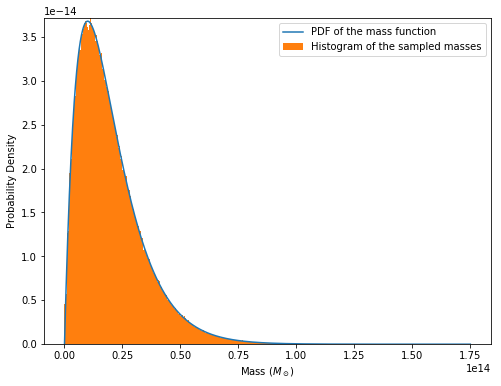

In [6]:
# Plot over a range of masses
M = np.linspace(0, 1.75e14, 1000)

plt.figure(figsize=(8,6))

# Plot the PDF
plt.plot(M, hmf_pdf(M), label="PDF of the mass function")

# Plot a normalized histogram
plt.hist(mass, density=True, bins='auto', label="Histogram of the sampled masses")

plt.xlabel("Mass ($M_\odot$)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

Evidently, the PDF and histogram agree well. The mass function differs from this plot only by a constant normalization factor (in this case, `norm_pdf`), so we may conclude that drawing from the inverted CDF gives the correct mass function.

#### What is the meaning of `map_mean`?
Note that I have renamed `map_1`, `map_sum`, and `map_mean` all to `flux_map` in the above code, for memory purposes. I will refer to the old names here. 

`map_mean` simply represents the mean flux in each x-y pixel of `map_1` where $\chi > \chi_{\mathrm{cut}}$. This allows us to determine the relative intensity of each pixel, whilst accounting for the range of distances that we included. A plot of this map is as follows. Note that we have ploted the transpose of the map, such that RA appears on the x-axis (since the first array dimension corresponds to the rows in `imshow`).

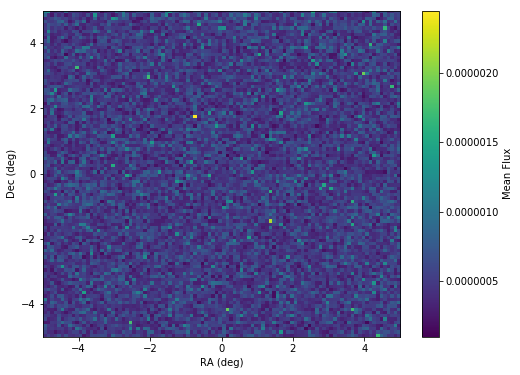

In [7]:
plt.figure(figsize=(8,6))
plt.imshow(flux_map.T, extent=[-fov_x/2, fov_x/2, -fov_y/2, fov_y/2], aspect='auto', origin='lower')
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.colorbar(label="Mean Flux")
plt.show()

#### Plot the histogram of the pixel intensities

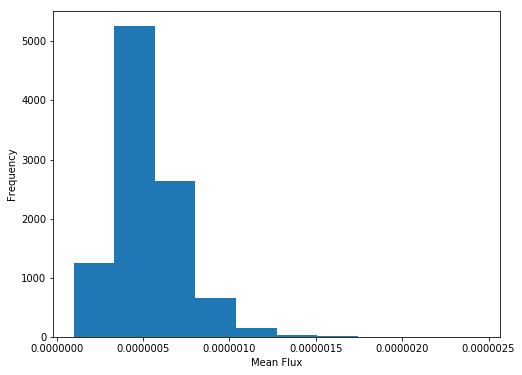

In [8]:
plt.figure(figsize=(8,6))
centres = (bin_edges[1:] + bin_edges[:-1])/2
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist)
plt.xlabel("Mean Flux")
plt.ylabel("Frequency")
plt.show()

#### Find and print the indices of the 10 brightest pixels
For this purpose we utilize the `numpy.partition` function, which partitions an array such that the $k^{\mathrm{th}}$ element appears where it would have appeared if the array were sorted. We use this function to find the tenth brightest pixel, and we find the remaining brightest pixels by comparison to the tenth largest.

In [9]:
# Find the tenth largest element by partitioning the data about said element
tenth_largest = np.partition(flux_map.flat, -10)[-10]

# Grab and print the indices greater or equal to the tenth largest
indices = np.where(flux_map >= tenth_largest)
indices = np.vstack(indices)
print(indices.T)

[[ 9 82]
 [24  4]
 [29 79]
 [42 67]
 [51  8]
 [63 35]
 [86  8]
 [89 80]
 [93  0]
 [97 76]]


We can also convert these to RA and Dec, for comparison with the 2D histogram above.

In [10]:
indices = indices.astype(float)
indices[0] = indices[0] * dx_pix - fov_x/2 + dx_pix/2 # add dx_pix/2 to centre on each pixel
indices[1] = indices[1] * dy_pix - fov_y/2 + dy_pix/2
print(indices.T)

[[-4.05  3.25]
 [-2.55 -4.55]
 [-2.05  2.95]
 [-0.75  1.75]
 [ 0.15 -4.15]
 [ 1.35 -1.45]
 [ 3.65 -4.15]
 [ 3.95  3.05]
 [ 4.35 -4.95]
 [ 4.75  2.65]]


Plotting these over the 2D histogram gives:

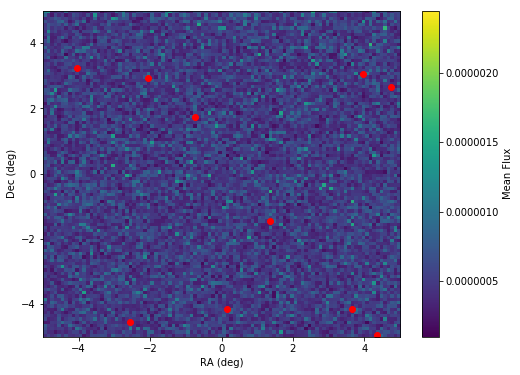

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(flux_map.T, extent=[-fov_x/2, fov_x/2, -fov_y/2, fov_y/2], aspect='auto', origin='lower')
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.colorbar(label="Mean Flux")
plt.scatter(*indices, color='red')
plt.xlim(-fov_x/2, fov_x/2)
plt.ylim(-fov_y/2, fov_y/2)
plt.show()